In this notebook, we are going to fine-tune `SegFormerForImageSegmentation` on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 3.5 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 28.3 MB/s 
     |████████████████████████████████| 6.8 MB 33.4 MB/s 
     |████████████████████████████████| 895 kB 11.9 MB/s 
     |████████████████████████████████| 67 kB 1.9 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/toy_brain /content/

## Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

In [ ]:
from torch.utils.data import Dataset
import os
from PIL import Image

class ImageSegmentationDataset(Dataset):
    """Image segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)
        
        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)
        
        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        
        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt")

        for k,v in encoded_inputs.items():
          encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets:

In [ ]:
# ! pip install --upgrade transformers

In [ ]:
from transformers import SegformerFeatureExtractor

root_dir = 'toy_brain'
feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=True)

train_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = ImageSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 3138
Number of validation examples: 781


Let's verify a random example:

In [ ]:
encoded_inputs = train_dataset[0]

In [ ]:
encoded_inputs["pixel_values"].shape

torch.Size([3, 512, 512])

In [ ]:
encoded_inputs["labels"].shape

torch.Size([512, 512])

In [ ]:
encoded_inputs["labels"]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
encoded_inputs["labels"].squeeze().unique()

tensor([0])

Next, we define corresponding dataloaders.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))

In [ ]:
for k,v in batch.items():
  print(k, v.shape)

pixel_values torch.Size([2, 3, 512, 512])
labels torch.Size([2, 512, 512])


In [ ]:
batch["labels"].shape

torch.Size([2, 512, 512])

In [ ]:
mask = (batch["labels"] != 255)
mask

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]],

        [[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [ ]:
batch["labels"][mask]

tensor([0, 0, 0,  ..., 0, 0, 0])

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k. We also set the `id2label` and `label2id` mappings.

In [ ]:
from transformers import SegformerForSemanticSegmentation
import json

id2label = {0: 'background', 1: 'tumor'}
label2id = {v: k for k, v in id2label.items()}
with open('tumor-id2label.json', 'w') as fp:
    json.dump(id2label, fp)
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b0", ignore_mismatched_sizes=True,
                                                         num_labels=2, id2label=id2label, label2id=label2id,
                                                         reshape_last_stage=True)

Downloading:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at nvidia/mit-b0 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.linear_c.2.proj.weight', 'decode_head.batch_norm.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.num_batches_tracked', 'decode

## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

In [ ]:
from transformers import AdamW
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=0.00006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(3):  # loop over the dataset multiple times
    total_accuracy = 0
    total_loss = 0

    for i, batch in enumerate((train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)

        # evaluate
        upsampled_logits = nn.functional.interpolate(outputs.logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
        predicted = upsampled_logits.argmax(dim=1)

        mask = (labels != 255) # we don't include the background class in the accuracy calculation
        pred_labels = predicted[mask].detach().cpu().numpy()
        true_labels = labels[mask].detach().cpu().numpy()
        total_accuracy += accuracy_score(pred_labels, true_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print("Epoch {}  | Loss: {:.3f}  | Pixel-wise accuracy: {:.3f}".format(epoch+1,total_loss/(i+1),total_accuracy/(i+1)))

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch 1  | Loss: 0.056  | Pixel-wise accuracy: 0.995
Epoch 2  | Loss: 0.002  | Pixel-wise accuracy: 1.000


## Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

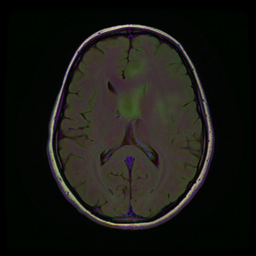

In [ ]:
image = Image.open('toy_brain/images/training/TCGA_DU_8166_19970322_19.tif')
image

In [ ]:
# prepare the image for the model (aligned resize)
feature_extractor_inference = SegformerFeatureExtractor(do_random_crop=False, do_pad=False)

pixel_values = feature_extractor_inference(image, return_tensors="pt").pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 512, 512])


In [ ]:
# forward pass
outputs = model(pixel_values=pixel_values)

In [ ]:
# logits are of shape (batch_size, num_labels, height/4, width/4)
logits = outputs.logits.cpu()
print(logits.shape)

torch.Size([1, 2, 128, 128])


In [ ]:
def tumor_palette():
    """Tumor  palette that maps each class to RGB values."""
    return [[0,0,0],[255, 255, 255]]


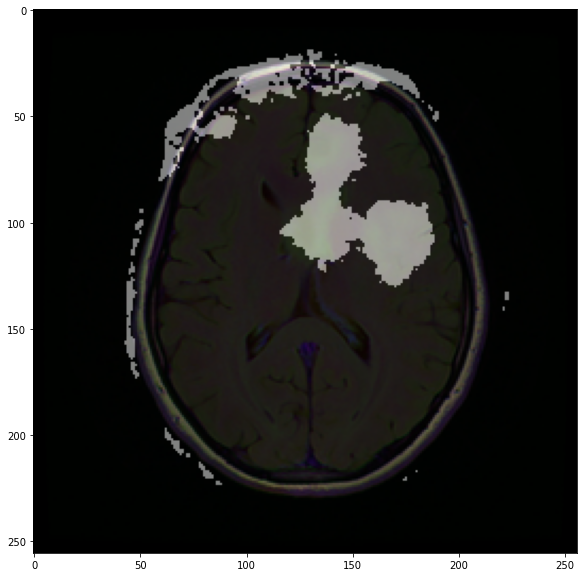

In [ ]:
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(tumor_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

Compare this to the ground truth segmentation map:

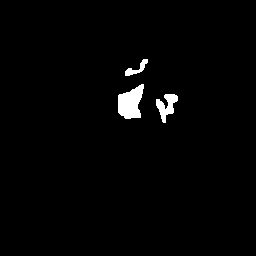

In [ ]:
map = Image.open('toy_brain/annotations/training/TCGA_DU_8166_19970322_19_mask.tif') 
map 

Classes in this image: ['background', 'tumor']


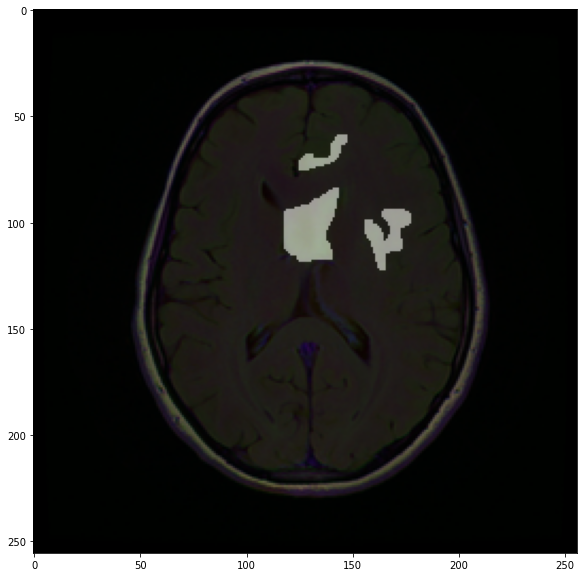

In [ ]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 0 # background class is replaced by ignore_index
#map = map - 1 # other classes are reduced by one
map[map == 255] = 1

classes_map = np.unique(map).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(tumor_palette())
for label, color in enumerate(palette):
    #print('label, color: ',label, color)
    color_seg[map == label, :] = color
#Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
seg

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

Let's compute the pixel-wise accuracy:

In [ ]:
mask = (map != 255) # we don't include the background class in the accuracy calculation
pred_labels = seg[mask].numpy()
true_labels = map[mask]

print(accuracy_score(pred_labels, true_labels))

0.9893035888671875
